<a href="https://colab.research.google.com/github/Gomez-Lab/WoundSizeEstimation/blob/main/Detection_Training%2C_pre_processing_and_exploration.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Original Image Classification and YOLO Detection notebook

This is the original code attempting to classify the original images (non cropped) to their corresponding day number.

Later on I also train the YOLOv3 wound detector. A seperate notebook will cover inference for ease of use.

### Support for importing files from drive

In [ ]:
!nvidia-smi

Sun Aug  2 23:59:40 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.57       Driver Version: 418.67       CUDA Version: 10.1     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                 ERR! |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


## Data exploration

In [ ]:
%cd /content/drive/My\ Drive/Hector_MJ_Google_Drive/Hector_MJ/Mouse\ wounds/Age\ Classification

/content/drive/.shortcut-targets-by-id/175Vkdh2mGaZ7CZsZetvNssl0puand1tS/Hector_MJ_Google_Drive/Hector_MJ/Mouse wounds/Wound Detection


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import seaborn as sns
import tensorflow as tf
import keras
from keras import layers
from keras.applications import DenseNet121
from keras.callbacks import Callback, ModelCheckpoint
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.models import Sequential
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from keras.preprocessing.image import ImageDataGenerator
sns.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


We can load our day label dataframes, they are found in the `Age Classification` folder on google drive.



In [ ]:
IMG_SIZE = 320 # Could use some other target size

train_df = pd.read_csv("train.csv", delimiter = ",")
val_df = pd.read_csv("val.csv", delimiter = ",")
test_df = pd.read_csv("test.csv", delimiter = ",")

labels = ["Day 0", "Day 1", "Day 2", "Day 3", "Day 4", "Day 5", "Day 6", 
          "Day 7", "Day 8", "Day 9", "Day 10", "Day 11", "Day 12",
          "Day 13", "Day 14", "Day 15"]

Display Random Images


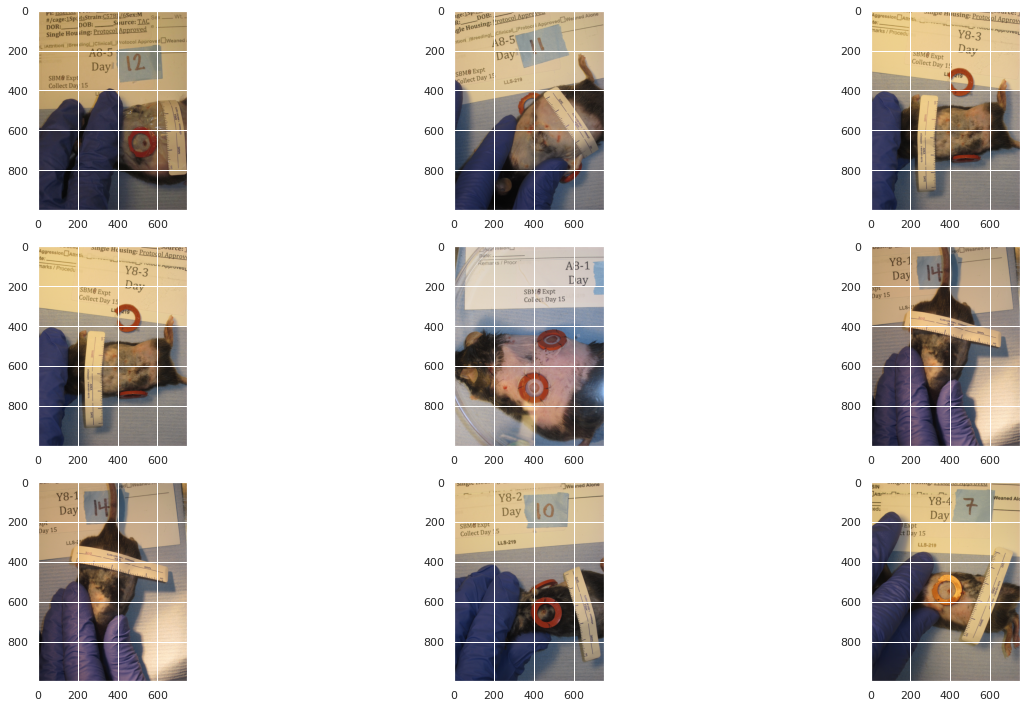

In [ ]:
# Extract numpy values from Image column in data frame
images = test_df['File'].values

# Extract 9 random images from it
random_images = [np.random.choice(images) for i in range(9)]

# Location of the image dir
img_dir = 'Test/'

print('Display Random Images')

# Adjust the size of your images
plt.figure(figsize=(20,10))

# Iterate and plot random images
for i in range(9):
    plt.subplot(3, 3, i + 1)
    img = plt.imread(os.path.join(img_dir, random_images[i]))
    plt.imshow(img)
    plt.axis('on')
    
# Adjust subplot parameters to give specified padding
plt.tight_layout()

The dimensions of the image are 1000 pixels width and 750 pixels height, with 4 color channels
The maximum pixel value is 1.0000 and the minimum is 0.0157
The mean value of the pixels is 0.5925 and the standard deviation is 0.3085


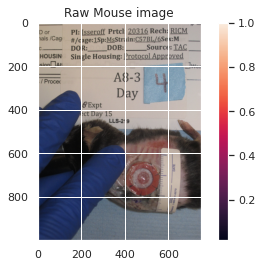

In [ ]:
# Get the first image that was listed in the train_df dataframe
sample_img = test_df.File[0]
raw_image = plt.imread(os.path.join(img_dir, sample_img))
plt.imshow(raw_image)
plt.colorbar()
plt.title('Raw Mouse image')
print(f"The dimensions of the image are {raw_image.shape[0]} pixels width and {raw_image.shape[1]} pixels height, with {raw_image.shape[2]} color channels")
print(f"The maximum pixel value is {raw_image.max():.4f} and the minimum is {raw_image.min():.4f}")
print(f"The mean value of the pixels is {raw_image.mean():.4f} and the standard deviation is {raw_image.std():.4f}")

Text(0, 0.5, '# Pixels in Image')

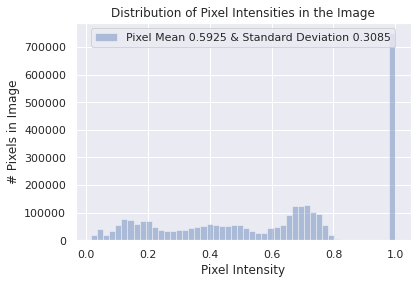

In [ ]:
# Plot a histogram of the distribution of the pixels
sns.distplot(raw_image.ravel(), 
             label=f'Pixel Mean {np.mean(raw_image):.4f} & Standard Deviation {np.std(raw_image):.4f}', kde=False)
plt.legend(loc='upper center')
plt.title('Distribution of Pixel Intensities in the Image')
plt.xlabel('Pixel Intensity')
plt.ylabel('# Pixels in Image')

In [ ]:
# Normalize images
image_generator = ImageDataGenerator(
    samplewise_center = True, #Set each sample mean to 0.
    samplewise_std_normalization = True # Divide each input by its standard deviation
)

In [ ]:
# Flow from directory with specified batch size and target image size
generator = image_generator.flow_from_dataframe(
        dataframe = test_df,
        directory = img_dir,
        x_col = "File", # features
        y_col = labels, # labels
        class_mode = "raw", # 'Mass' column should be in train_df
        batch_size = 1, # images per batch
        shuffle = False, # shuffle the rows or not
        target_size = (IMG_SIZE, IMG_SIZE) # width and height of output image
)

Found 32 validated image filenames.


In [ ]:
# Plot a processed image
sns.set_style("white")
generated_image, label = generator.__getitem__(0)

print(f"The dimensions of the image are {generated_image.shape[1]} pixels width and {generated_image.shape[2]} pixels height")
print(f"The maximum pixel value is {generated_image.max():.4f} and the minimum is {generated_image.min():.4f}")
print(f"The mean value of the pixels is {generated_image.mean():.4f} and the standard deviation is {generated_image.std():.4f}")

The dimensions of the image are 320 pixels width and 320 pixels height
The maximum pixel value is 2.3237 and the minimum is -1.9148
The mean value of the pixels is 0.0000 and the standard deviation is 1.0000


## Datagen

In [ ]:
train_generator = image_generator.flow_from_dataframe(
    dataframe = train_df,
    directory = "Train/",
    x_col = "File",
    y_col = labels,
    batch_size = 16,
    shuffle = True,
    class_mode = "raw",
    target_size = (IMG_SIZE, IMG_SIZE))

Found 190 validated image filenames.


In [ ]:
def get_test_and_valid_generator(valid_df, test_df, train_df, y_cols, x_col = 'File', sample_size=100, batch_size=16, seed=1, target_w = 320, target_h = 320):
    """
    Return generator for validation set and test test set using
    normalization statistics from training set.
    Args:
      valid_df (dataframe): dataframe specifying validation data.
      test_df (dataframe): dataframe specifying test data.
      train_df (dataframe): dataframe specifying training data.
      image_dir (str): directory where image files are held.
      x_col (str): name of column in df that holds filenames.
      y_cols (list): list of strings that hold y labels for images.
      sample_size (int): size of sample to use for normalization statistics.
      batch_size (int): images per batch to be fed into model during training.
      seed (int): random seed.
      target_w (int): final width of input images.
      target_h (int): final height of input images.
    Returns:
        test_generator (DataFrameIterator) and valid_generator: iterators over test set and validation set respectively
    """
    print("getting test images for normalization...")
    # get generator to sample dataset
    raw_train_generator = ImageDataGenerator().flow_from_dataframe(
        dataframe = train_df,
        directory = "Train/",
        x_col = "File",
        y_col = y_cols,
        class_mode = "raw",
        batch_size=sample_size,
        shuffle = True,
        target_size=(target_w, target_h))

    print("getting test and val generators...")
    # get data sample
    batch = raw_train_generator.next()
    data_sample = batch[0]

    # use sample to fit mean and std for test set generator
    image_generator = ImageDataGenerator(
        featurewise_center = True,
        featurewise_std_normalization = True)

    # fit generator to sample from training data
    image_generator.fit(data_sample)

    # get test generator
    valid_generator = image_generator.flow_from_dataframe(
            dataframe = valid_df,
            directory = "Val/",
            x_col = "File",
            y_col = y_cols,
            class_mode = "raw",
            batch_size = batch_size,
            shuffle = False,
            target_size=(target_w,target_h))

    test_generator = image_generator.flow_from_dataframe(
            dataframe = test_df,
            directory = "Test/",
            x_col = "File",
            y_col = y_cols,
            class_mode = "raw",
            batch_size = batch_size,
            shuffle = False,
            target_size=(target_w,target_h))
    
    return valid_generator, test_generator

In [ ]:
val_generator, test_generator = get_test_and_valid_generator(val_df, test_df, train_df, labels)

getting test images for normalization...
Found 190 validated image filenames.
getting test and val generators...
Found 32 validated image filenames.
Found 32 validated image filenames.


In [ ]:
x.shape

(16, 320, 320, 3)

16 batch size, image size x image size, 3 chanels

In [ ]:
y.shape

(16, 16)

Labels

## DenseNet Train (transfer learned)

In [ ]:
IN_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

densenet = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape = IN_SHAPE
)

29089792/29084464 [==============================] - 0s 0us/step


In [ ]:
densenet.summary()

Model: "densenet121"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 320, 320, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 326, 326, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 160, 160, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 160, 160, 64) 256         conv1/conv[0][0]                 
________________________________________________________________________________________

In [ ]:
model = Sequential()
model.add(densenet)
model.add(layers.GlobalAveragePooling2D())
model.add(layers.Dense(16, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
densenet121 (Model)          (None, 10, 10, 1024)      7037504   
_________________________________________________________________
global_average_pooling2d_3 ( (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 16)                16400     
Total params: 7,053,904
Trainable params: 6,970,256
Non-trainable params: 83,648
_________________________________________________________________


In [ ]:
import h5py
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping

earlystop = EarlyStopping(monitor = 'val_loss',
                          min_delta = 0,
                          patience = 5,
                          verbose = 1,
                          restore_best_weights = True)

best_model_file = "./DenseWound.h5"
best_model = ModelCheckpoint(best_model_file,
                             monitor = 'val_loss',
                             mode = 'auto',
                             verbose = 1,
                             save_best_only = True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor = 0.1,
                              patience = 3,
                              min_lr = 0.00001,
                              verbose = 1)

tensor_board = tbCallBack = TensorBoard(log_dir = './logs',
                                        histogram_freq = 0,
                                        write_graph = True,
                                        write_images = False)

callback_list = [reduce_lr, earlystop, best_model, tensor_board]

history = model.fit_generator(train_generator, 
                              validation_data = val_generator,
                              steps_per_epoch = 100, 
                              validation_steps = 25, 
                              epochs = 8,
                              verbose = 1,
                              callbacks = callback_list)

Epoch 1/8
  2/100 [..............................] - ETA: 34:36 - loss: 2.8255 - accuracy: 0.2000      

/usr/local/lib/python3.6/dist-packages/keras/callbacks/callbacks.py:95: RuntimeWarning: Method (on_train_batch_end) is slow compared to the batch update (0.710079). Check your callbacks.
  % (hook_name, delta_t_median), RuntimeWarning)


100/100 [==============================] - 150s 2s/step - loss: 0.1979 - accuracy: 0.9501 - val_loss: 5.5372 - val_accuracy: 0.4100

Epoch 00001: val_loss improved from inf to 5.53725, saving model to ./vesta.h5
Epoch 2/8
100/100 [==============================] - 106s 1s/step - loss: 0.0112 - accuracy: 0.9994 - val_loss: 0.6953 - val_accuracy: 0.8125

Epoch 00002: val_loss improved from 5.53725 to 0.69525, saving model to ./vesta.h5
Epoch 3/8
100/100 [==============================] - 109s 1s/step - loss: 0.0011 - accuracy: 1.0000 - val_loss: 0.6095 - val_accuracy: 0.8725

Epoch 00003: val_loss improved from 0.69525 to 0.60946, saving model to ./vesta.h5
Epoch 4/8
100/100 [==============================] - 105s 1s/step - loss: 4.1349e-04 - accuracy: 1.0000 - val_loss: 0.1850 - val_accuracy: 0.9075

Epoch 00004: val_loss improved from 0.60946 to 0.18500, saving model to ./vesta.h5
Epoch 5/8
100/100 [==============================] - 105s 1s/step - loss: 3.3458e-04 - accuracy: 1.0000 - 

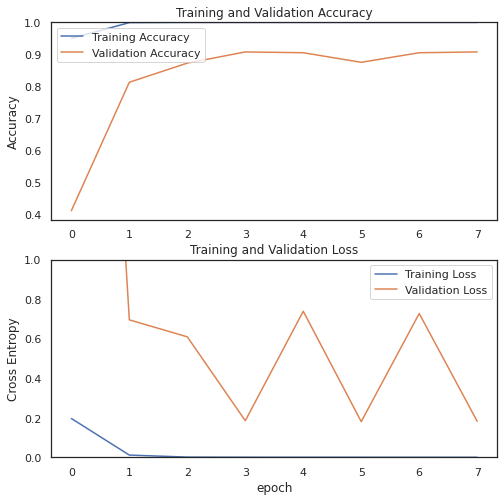

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='upper left')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

## Eval

In [ ]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.predict_generator(test_generator, steps=2)
print("test loss, test acc:", results)

Evaluate on test data
test loss, test acc: [[1.27859812e-06 8.09050471e-06 3.37263053e-08 7.62376658e-06
  9.99962568e-01 1.36014776e-07 7.30250065e-08 1.24448752e-06
  9.05655099e-07 7.74236469e-07 2.92505376e-07 1.22108872e-06
  3.36633548e-06 3.29274485e-06 1.78525238e-06 7.28926716e-06]
 [2.84905855e-06 4.87128986e-08 5.43011041e-08 1.12579380e-06
  4.10895609e-06 3.21828186e-09 3.44300588e-09 9.99967933e-01
  7.01749173e-07 2.24222254e-06 3.42871473e-08 9.20116392e-08
  1.73325446e-07 2.03269919e-05 1.89896923e-07 2.28972937e-07]
 [5.42586440e-06 7.33532306e-06 1.06168798e-08 6.17567730e-06
  8.46045168e-06 3.81704979e-07 9.83682276e-06 2.53028338e-06
  3.08644019e-07 4.71631211e-06 1.75825937e-06 3.64187230e-07
  2.55789837e-06 9.99340355e-01 7.04013701e-06 6.02767221e-04]
 [2.58644490e-04 3.04921111e-03 1.11356778e-04 1.00309448e-03
  7.70494167e-04 1.20534285e-04 7.18597829e-01 3.16717220e-03
  5.00275870e-04 5.99861071e-02 1.84060752e-01 5.52394614e-03
  2.04083938e-02 1.91358

In [ ]:
results.shape

(32, 16)

In [ ]:
np.argmax(results[0])

4

In [ ]:
ground_truth = [4, 7, 13, 6, 2, 11, 10, 12, 8, 5, 1, 0, 15, 3, 14, 9, 8, 2, 8, 14, 15, 14, 5, 1, 10, 0, 3, 12, 4, 7, 6, 11]

In [ ]:
predictions = []
for result in results:
    predictions.append(np.argmax(result))

In [ ]:
len(ground_truth)

32

In [ ]:
false = 0
for p, t in zip(predictions, ground_truth):
    print("predicted: ", p, "truth: ", t)
    if p != t:
        false += 1

print()
print("incorrect: ", false, "/", len(predictions))
print("accuracy: ", (len(predictions) - false) / len(predictions), "%")

predicted:  4 truth:  4
predicted:  7 truth:  7
predicted:  13 truth:  13
predicted:  6 truth:  6
predicted:  2 truth:  2
predicted:  11 truth:  11
predicted:  10 truth:  10
predicted:  12 truth:  12
predicted:  8 truth:  8
predicted:  5 truth:  5
predicted:  1 truth:  1
predicted:  13 truth:  0
predicted:  15 truth:  15
predicted:  3 truth:  3
predicted:  14 truth:  14
predicted:  9 truth:  9
predicted:  8 truth:  8
predicted:  2 truth:  2
predicted:  8 truth:  8
predicted:  13 truth:  14
predicted:  15 truth:  15
predicted:  14 truth:  14
predicted:  5 truth:  5
predicted:  1 truth:  1
predicted:  10 truth:  10
predicted:  0 truth:  0
predicted:  3 truth:  3
predicted:  12 truth:  12
predicted:  4 truth:  4
predicted:  7 truth:  7
predicted:  6 truth:  6
predicted:  11 truth:  11

incorrect:  2 / 32
accuracy:  0.9375 %


We get a 93% top-1 accuracy on the test set

# YOLOv3 wound detection

The folder containing the training data is `Wound Detection/dataset` on google drive

In [ ]:
%cd /content/drive/My\ Drive/Hector_MJ_Google_Drive/Hector_MJ/Mouse\ wounds/Wound\ Detection/yolov3/

In [ ]:
%load_ext tensorboard
import tensorflow as tf
import datetime, os

## Training

In [ ]:
!python3 train.py --single-cls --data ./data/wound.data --cfg ./cfg/project.cfg --epochs 400

Apex recommended for faster mixed precision training: https://github.com/NVIDIA/apex
Namespace(adam=False, batch_size=16, bucket='', cache_images=False, cfg='./cfg/project.cfg', data='./data/wound.data', device='', epochs=400, evolve=False, freeze_layers=False, img_size=[320, 640], multi_scale=False, name='', nosave=False, notest=False, rect=False, resume=False, single_cls=True, weights='weights/yolov3-spp-ultralytics.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Start Tensorboard with "tensorboard --logdir=runs", view at http://localhost:6006/
2020-08-01 23:36:07.295697: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Model Summary: 225 layers, 6.25733e+07 parameters, 6.25733e+07 gradients
Optimizer groups: 76 .bias, 76 Conv2d.weight, 73 other
Caching labels data/train_full.txt (252 found, 0 missing, 0 empty, 0 duplicate, for 252 images): 100% 252/252 [00:00<00:00,

## Resume Training on new Data

In [ ]:
!python3 train.py --resume --epochs 50 --batch-size 8 --data ./data/new_wound.data --cfg ./cfg/project.cfg

Apex recommended for faster mixed precision training: https://github.com/NVIDIA/apex
Namespace(adam=False, batch_size=4, bucket='', cache_images=False, cfg='./cfg/project.cfg', data='./data/new_wound.data', device='', epochs=50, evolve=False, freeze_layers=False, img_size=[320, 640], multi_scale=False, name='', nosave=False, notest=False, rect=False, resume=True, single_cls=False, weights='weights/yolov3-spp-ultralytics.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla K80', total_memory=11441MB)

Start Tensorboard with "tensorboard --logdir=runs", view at http://localhost:6006/
2020-08-01 17:15:24.974442: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudart.so.10.1
Model Summary: 225 layers, 6.25733e+07 parameters, 6.25733e+07 gradients
Optimizer groups: 76 .bias, 76 Conv2d.weight, 73 other
Caching labels data/new_train.txt (34 found, 0 missing, 0 empty, 0 duplicate, for 34 images): 100% 34/34 [00:00<00:00, 735.45it/s]
C

## Eval

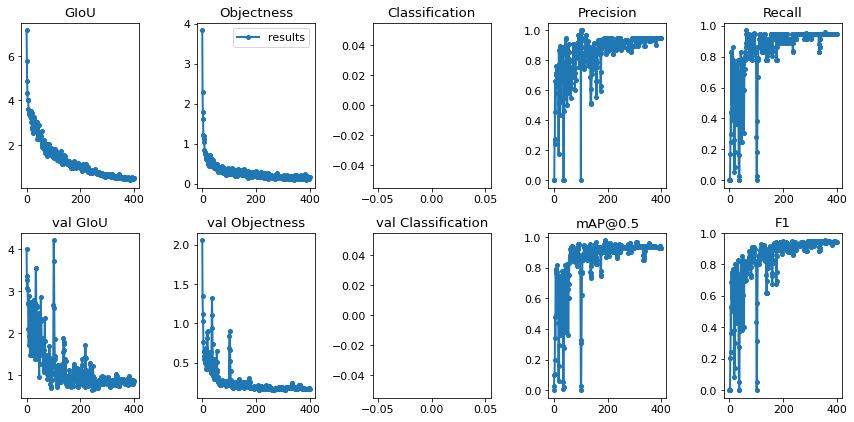

In [ ]:
from utils import utils; utils.plot_results()

In [ ]:
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 9971), started 0:07:34 ago. (Use '!kill 9971' to kill it.)

<IPython.core.display.Javascript object>

## Detection

In [ ]:
!python3 detect.py --weights weights/last.pt --cfg ./cfg/project.cfg --names ./data/label.names --save-txt

Namespace(agnostic_nms=False, augment=False, cfg='./cfg/project.cfg', classes=None, conf_thres=0.3, device='', fourcc='mp4v', half=False, img_size=512, iou_thres=0.6, names='./data/label.names', output='output', save_txt=True, source='data/samples', view_img=False, weights='weights/last.pt')
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Model Summary: 225 layers, 6.25733e+07 parameters, 6.25733e+07 gradients
image 1/160 data/samples/Michelle - A6-1L Dy1.jpg: 512x384 1 Wounds, Done. (0.018s)
image 2/160 data/samples/Michelle - A6-1R Dy1.jpg: 512x384 1 Wounds, Done. (0.018s)
image 3/160 data/samples/Michelle - A6-2L Dy1.jpg: 512x384 1 Wounds, Done. (0.018s)
image 4/160 data/samples/Michelle - A6-2R Dy1.jpg: 512x384 1 Wounds, Done. (0.018s)
image 5/160 data/samples/Michelle - A6-3L Dy1.jpg: 512x384 1 Wounds, Done. (0.018s)
image 6/160 data/samples/Michelle - A6-3R Dy1.jpg: 512x384 1 Wounds, Done. (0.018s)
image 7/160 data/samples/Michelle - A

### Crop experimentation

A separate notebook will cover the cropping algorithm

In [ ]:
import os
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

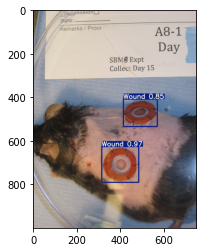

In [ ]:
image = Image.open('Day 0_A8-1-L.png')

im_array = np.asarray(image)
plt.imshow(im_array)
plt.show()

In [ ]:
width, height = image.size
print(width, height)

750 1000


In [ ]:
x = 0.531333 * width
y = 0.708 * height

In [ ]:
cropWidth = ((0.225333 * width) / 2) - 2
cropHeight = ((0.164 * height) / 2) - 2

In [ ]:
left = x - cropWidth
right = x + cropWidth

top = y - cropHeight
bottom = y + cropHeight

In [ ]:
crop = image.crop((left, top, right, bottom))
crop.size
crop.save('../Crops/test.png')

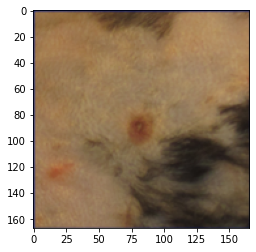

In [ ]:
im_array = np.asarray(crop)
plt.imshow(im_array)
plt.show()

In [ ]:
for fileName in os.listdir():

    if fileName[-4:] == '.png':
        with open(fileName[:-4] + '.txt') as info:

            points = (info.readline().split(" "))

            image = Image.open(fileName)
            width, height = image.size
            x = float(points[1]) * width
            y = float(points[2]) * height
            cropWidth = ((float(points[3]) * width) / 2) - 2
            cropHeight = ((float(points[4]) * height) / 2) - 2
            left = x - cropWidth
            right = x + cropWidth
            top = y - cropHeight
            bottom = y + cropHeight

            crop = image.crop((left, top, right, bottom))
            crop.save('../Crops/' + fileName)

In [ ]:
points

[['0', '0.531333', '0.708', '0.225333', '0.164', '\n'],
 ['0', '0.351333', '0.828', '0.225333', '0.17', '\n'],
 ['0', '0.361333', '0.5825', '0.221333', '0.167', '\n'],
 ['0', '0.354667', '0.6685', '0.218667', '0.167', '\n'],
 ['0', '0.380667', '0.607', '0.217333', '0.162', '\n'],
 ['0', '0.479333', '0.764', '0.217333', '0.162', '\n'],
 ['0', '0.387333', '0.63', '0.225333', '0.166', '\n'],
 ['0', '0.566', '0.775', '0.225333', '0.168', '\n'],
 ['0', '0.546', '0.769', '0.217333', '0.162', '\n'],
 ['0', '0.544', '0.712', '0.221333', '0.166', '\n'],
 ['0', '0.428', '0.714', '0.224', '0.166', '\n'],
 ['0', '0.538', '0.7155', '0.222667', '0.165', '\n'],
 ['0', '0.568667', '0.3145', '0.212', '0.163', '\n'],
 ['0', '0.703333', '0.34', '0.214667', '0.164', '\n'],
 ['0', '0.477333', '0.491', '0.224', '0.164', '\n'],
 ['0', '0.436667', '0.7235', '0.217333', '0.161', '\n'],
 ['0', '0.704667', '0.6065', '0.228', '0.175', '\n'],
 ['0', '0.73', '0.5855', '0.233333', '0.171', '\n'],
 ['0', '0.808', '0.

In [ ]:
float(points[0][1])

0.531333